# Problem Definition
### Sparkify Churn Prediction

We want to create a churn prediction classifier.

We will use data from a fictive company called Sparkify, a music streaming company. The dataset contains all kinds of events created by the users who interacted with
the platform. Such as when they logged in, when they are listening to music, and when they are unsubscribing from the platform.

The goal of this notebook is to leverage this data to create a model that can forecast customer churn. Therefore, we can understand better why the users are leaving the platform
and we can adapt and improve their overall experience.

# Import Libraries

In [7]:
import findspark
findspark.init()

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, NaiveBayes
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql.types import LongType

# Define Spark Session

In [65]:
spark = SparkSession.\
    builder.\
    appName("Sparkify Churn Prediction").\
    config("spark.jars.packages", "ml.dmlc:xgboost4j-spark:1.5.2").\
    getOrCreate()

24/05/27 17:50:59 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


# Load and Clean Dataset

In [11]:
EVENT_DATA_LINK = "mini_sparkify_event_data.json"
df = spark.read.json(EVENT_DATA_LINK)
df.persist()

df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



We can observe that all the columns are `strings` or `longs`.

In [12]:
df.show(n=10)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|       NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Bost

## Check for Empty Values

### Check for NaNs

In [13]:
df.select([F.count(F.when(F.isnan(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



There are no `nans` within the data.

### Check for Nones

In [14]:
df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



Instead of `nans` the missing entries are filled with `Nones`.

### Check for Empty Strings

In [15]:
df.select([F.count(F.when(F.col(c) == "", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|  8346|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [16]:
df.filter(F.col("userId") != "").select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [17]:
df.filter(F.col("userId") != "").select("auth").groupby("auth").count().show()

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+



We can observe that some `users` have the `id` as an `empty string`. The number of open user ids, `8346`, equals the number of None properties, such as: `firstName`, `lastName`, `registration`, `userAgent`. Also, those events have the `auth` state `Cancelled` or `Logged In`. This means that the users who do not have an ID are those who `haven't registered`, yet, into the platform.

When the `artist`, `song`, and `length` columns are `None`, the user stays on pages that do not include listening to music.

## Check for Other Unwanted Symbols

In [18]:
df.select([F.count(F.when(F.col(c) == "-", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [19]:
df.select([F.count(F.when(F.col(c) == "NaN", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [20]:
df.select([F.count(F.when(F.col(c) == "None", c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



None of those symbols can be found within the dataset.

In [21]:
df.select([F.count(F.when(F.col(c).cast("int").isNull(), c)).alias(c) for c in df.columns]).show()

+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+---+---------+------+
|artist|  auth|firstName|gender|itemInSession|lastName|length| level|location|method|  page|registration|sessionId|  song|status| ts|userAgent|userId|
+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+---+---------+------+
|286277|286500|   286500|286500|            0|  286500| 58392|286500|  286500|286500|286500|        8346|        0|286110|     0|  0|   286500|  8346|
+------+------+---------+------+-------------+--------+------+------+--------+------+------+------------+---------+------+------+---+---------+------+



There are no `sessionIds` that couldn't be cast to an int type.

## Unregistered Users

### Check Unregistered Users Page Distribution

In [22]:
df.filter(F.col("userId") == "").select("page").groupby("page").count().show()

+-------------------+-----+
|               page|count|
+-------------------+-----+
|               Home| 4375|
|              About|  429|
|              Login| 3241|
|               Help|  272|
|              Error|    6|
|           Register|   18|
|Submit Registration|    5|
+-------------------+-----+



Because there is no valuable activity for churn prediction performed by empty users, we can drop them out of the DataFrame.

## Drop Unregistered Users

In [23]:
cleaned_df = df.filter(F.col("userId") != "")
cleaned_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



## Empty Artists

### Check Empty Artists Distribution

In [24]:
df.filter(F.isnull(F.col("artist"))).select(["artist", "song", "userId", "page"]).show()

+------+----+------+---------------+
|artist|song|userId|           page|
+------+----+------+---------------+
|  NULL|NULL|    30|Add to Playlist|
|  NULL|NULL|     9|    Roll Advert|
|  NULL|NULL|     9|      Thumbs Up|
|  NULL|NULL|    54|      Downgrade|
|  NULL|NULL|    54|      Thumbs Up|
|  NULL|NULL|     9|    Thumbs Down|
|  NULL|NULL|     9|           Home|
|  NULL|NULL|     9|         Logout|
|  NULL|NULL|    74|      Thumbs Up|
|  NULL|NULL|      |           Home|
|  NULL|NULL|      |           Help|
|  NULL|NULL|      |           Home|
|  NULL|NULL|      |          Login|
|  NULL|NULL|     9|           Home|
|  NULL|NULL|    30|    Thumbs Down|
|  NULL|NULL|     4|         Logout|
|  NULL|NULL|      |           Home|
|  NULL|NULL|      |          Login|
|  NULL|NULL|     4|           Home|
|  NULL|NULL|    74|Add to Playlist|
+------+----+------+---------------+
only showing top 20 rows



In [25]:
df.filter(F.isnull(F.col("artist"))).select(["artist", "song", "userId", "page"]).groupby("page").count().show()

+--------------------+-----+
|                page|count|
+--------------------+-----+
|    Submit Downgrade|   63|
|         Thumbs Down| 2546|
|                Home|14457|
|           Downgrade| 2055|
|         Roll Advert| 3933|
|              Logout| 3226|
|       Save Settings|  310|
|               About|  924|
|            Settings| 1514|
|               Login| 3241|
|     Add to Playlist| 6526|
|          Add Friend| 4277|
|           Thumbs Up|12551|
|                Help| 1726|
|             Upgrade|  499|
|               Error|  258|
|      Submit Upgrade|  159|
|              Cancel|   52|
|Cancellation Conf...|   52|
|            Register|   18|
+--------------------+-----+
only showing top 20 rows



We can observe that when the artist is null, the users spend time on different pages than actually listening to music. In this case, such information is valuable for understanding the behavior of registered users.

### Impute empty values

In [26]:
# Fill the length of the song with 0.
# Fill the artist and the song with a string constant to signal that those pages don't have such information.
cleaned_df = cleaned_df.fillna({
    "length": 0,
    "artist": "unknown",
    "song": "unknown"
})
cleaned_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



Great! Now our data no longer has any `None` values. The last cleaning step is to check the types of the variables.

## Check Types

In [27]:
cleaned_df.printSchema()

root
 |-- artist: string (nullable = false)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = false)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = false)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [28]:
cleaned_df.show(n=5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

All the types are looking all right. We can proceed to EDA.

# Exploratory Data Analysis

### Define Churn

We will consider that a user is `churn` when the subscription is canceled.

In [29]:
cleaned_df.select(F.count(F.when(F.col("page") == "Cancellation Confirmation", "page")).alias("Cancellation Confirmation")).show()

+-------------------------+
|Cancellation Confirmation|
+-------------------------+
|                       52|
+-------------------------+



In [30]:
# First, create the churn event based on the visited page.
# The churnEvent will be different for every event/visited page.
labeled_df = cleaned_df.withColumn("churnEvent", F.when(F.col("page") == "Cancellation Confirmation", 1).otherwise(0))
labeled_df.show(n=5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churnEvent|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|         0|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-C

In [31]:
# Now create the churn label which is unique for every user.
labeled_df = labeled_df.withColumn("churn", F.sum("churnEvent").over(Window.partitionBy("userId")))
labeled_df = labeled_df.withColumn("churn", F.when(F.col("churn") >= 1, 1).otherwise(0))
labeled_df.filter(F.col("userId") == "122").show(n=100)

+--------------------+---------+---------+------+-------------+---------+---------+-----+-----------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|         location|method|                page| registration|sessionId|                song|status|           ts|           userAgent|userId|churnEvent|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+-----------------+------+--------------------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|             unknown|Logged In|    Molly|     F|            1|Patterson|      0.0| free|Memphis, TN-MS-AR|   GET|                Home|1535498705000|      403|             unknown|   200|1538657235000|Mozilla/5.0 (X11;...|   122|         0|    1|
|           

### Explore Data

In [32]:
palette = sns.color_palette("Set2")
sns.set_palette(palette)

##### Sample the Dataset for EDA
This is useful for when the full dataset is used.

In [33]:
mini_df_count = 278154
# Keep the number of records from the mini dataframe as a point of reference. If we use only the mini dataframe, then all the records will be used.
sampling_fraction = 278154 / labeled_df.count()
print(f"Sampling fraction for EDA: {sampling_fraction * 100:.2f}%")
eda_df = labeled_df.sample(withReplacement=False, fraction=sampling_fraction, seed=42)
eda_df.show(n=1)

Sampling fraction for EDA: 100.00%
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|churnEvent|churn|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|Sleeping With Sirens|Logged In| Darianna|     F|            0|Carpenter|202.97098| free|Bridgeport-Stamfo...|   PUT|NextSong|1538016340000|       31|Captain Tyin Knot...|   200|1539003534000|"Mozilla/5.0 (iPh...|100010|         0|    0|
+------------

#### Users Churn Distribution

/tmp/ipykernel_17359/2601669001.py:3: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '.5'}` instead.

  sns.barplot(data=user_churn_distribution, x="churn", y="count", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)


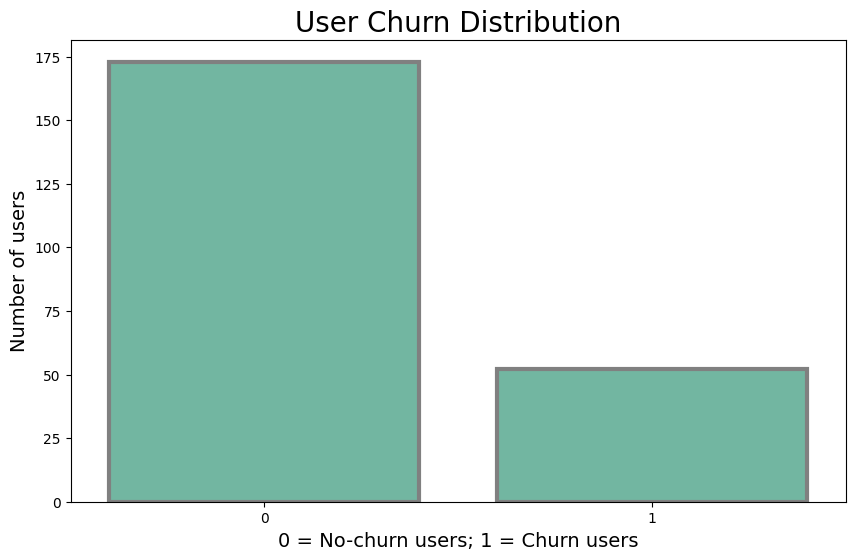

In [34]:
user_churn_distribution = eda_df.select(["userId", "churn"]).distinct().groupby("churn").count().toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=user_churn_distribution, x="churn", y="count", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("User Churn Distribution", fontsize=20)
ax.set_xlabel("0 = No-churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Number of users", fontsize=14)
fig.savefig("images/user_churn_distribution.jpg");

The distribution is highly skewed towards the `no-churn` users. That is why we will use the `F1` score to find the best model in the cross validation step.

#### Possible Pages

In [35]:
eda_df.select("page").distinct().show()

+--------------------+
|                page|
+--------------------+
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
|              Cancel|
|Cancellation Conf...|
+--------------------+



In [36]:
eda_df.filter(F.col("artist") != "unknown").select("page").distinct().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



The only page where music is played is called `NextSong`.

#### Gender Distribution

/tmp/ipykernel_17359/2841965689.py:3: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '.5'}` instead.

  sns.barplot(data=gender_distribution, x="churn", y="count", hue="gender", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)


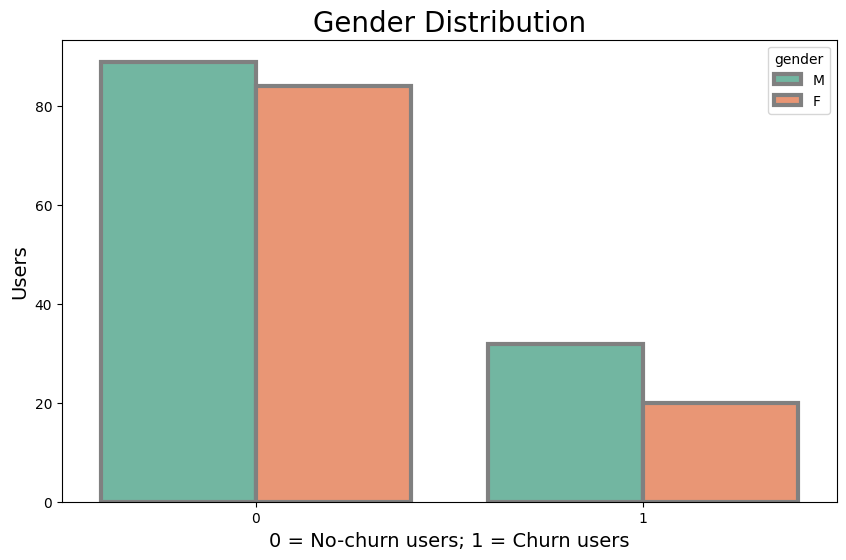

In [37]:
gender_distribution = eda_df.select(["churn", "userId", "gender"]).distinct().groupby(["churn", "gender"]).count().toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=gender_distribution, x="churn", y="count", hue="gender", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Gender Distribution", fontsize=20)
ax.set_xlabel("0 = No-churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Users", fontsize=14)
fig.savefig("images/gender_distribution.jpg");

Visually it seems that more males are in the churn group than females. But, we won't use this as a feature because the difference is not that big (to be 100%, we should statistically check the difference between the two distributions), and we don't want to bias the model towards gender.

#### Time Delta Since Registration

In [38]:
registration_delta_distribution = eda_df.alias("registration_delta_distribution")
registration_delta_distribution = registration_delta_distribution.withColumn("timeSinceRegistration", F.col("ts") - F.col("registration"))
registration_delta_distribution = registration_delta_distribution \
    .select(["churn", "userId", "timeSinceRegistration"]) \
    .groupby(["churn", "userId"]) \
    .agg(F.max(F.col("timeSinceRegistration")).alias("timeSinceRegistration")) \
    .toPandas()
registration_delta_distribution

,churn,userId,timeSinceRegistration
0,0,100,5605094000
1,0,100004,14898823000
2,1,100005,7360899000
3,1,100006,788587000
4,1,100007,9969490000
...,...,...,...
220,0,94,11431432000
221,0,95,5379812000
222,0,97,7550792000
223,0,115,6431581000


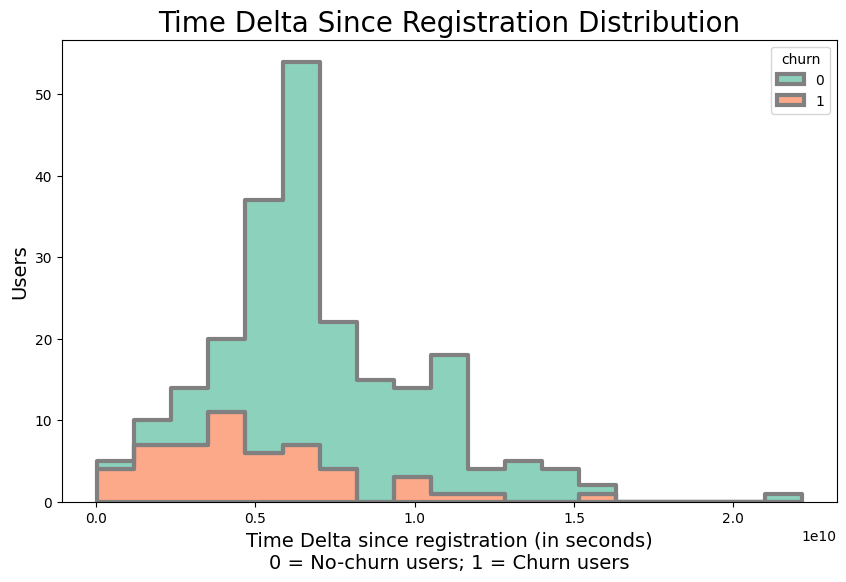

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.histplot(
    data=registration_delta_distribution,
    x="timeSinceRegistration",
    hue="churn",
    multiple="stack",
    linewidth=3,
    edgecolor=".5",
    element="step",
    ax=ax,
)
ax.set_title("Time Delta Since Registration Distribution", fontsize=20)
ax.set_xlabel("Time Delta since registration (in seconds)\n0 = No-churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Users", fontsize=14)
fig.savefig("images/registration_delta_distribution.jpg");

It looks like the timedelta since registration, for churn users, is right skewed. While the no-churn one is pretty normal. The mean of the timedelta is a good predictor.

#### Event Status Distribution

/tmp/ipykernel_17359/1735499370.py:3: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '.5'}` instead.

  sns.barplot(data=event_status_distribution, x="churn", y="count", hue="status", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)


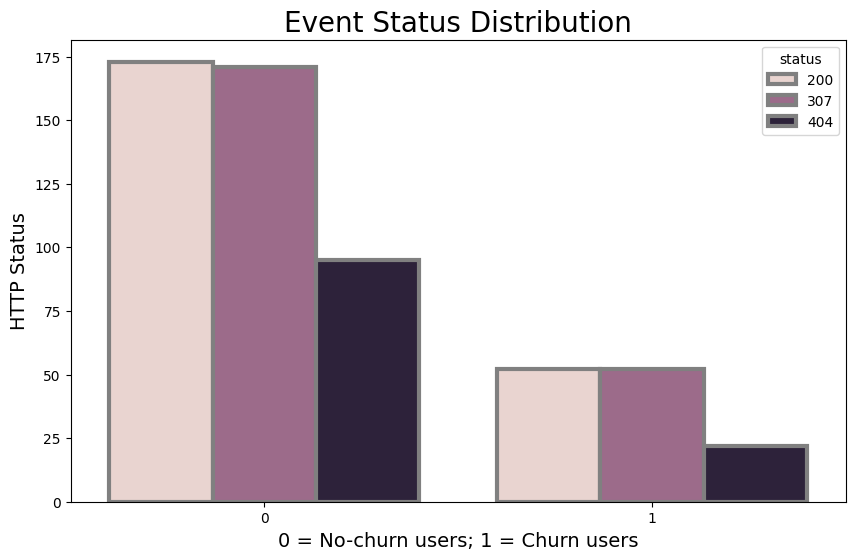

In [40]:
event_status_distribution = eda_df.select(["churn", "userId", "status"]).distinct().groupby(["churn", "status"]).count().toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=event_status_distribution, x="churn", y="count", hue="status", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Event Status Distribution", fontsize=20)
ax.set_xlabel("0 = No-churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("HTTP Status", fontsize=14)
fig.savefig("images/event_status_distribution.jpg");

The only status type that could mess with the user experience is `404`. But as we can see, it is evenly distributed between the `churn` and `no-churn` groups.

*NOTE:* A more robust verification can be performed with a proportion statistical test.

#### Distribution of the Average Number of Visited Pages by Every User

/tmp/ipykernel_17359/3177557139.py:3: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '.5'}` instead.

  sns.barplot(data=visited_pages_distribution, x="churn", y="Average Visited Pages", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)


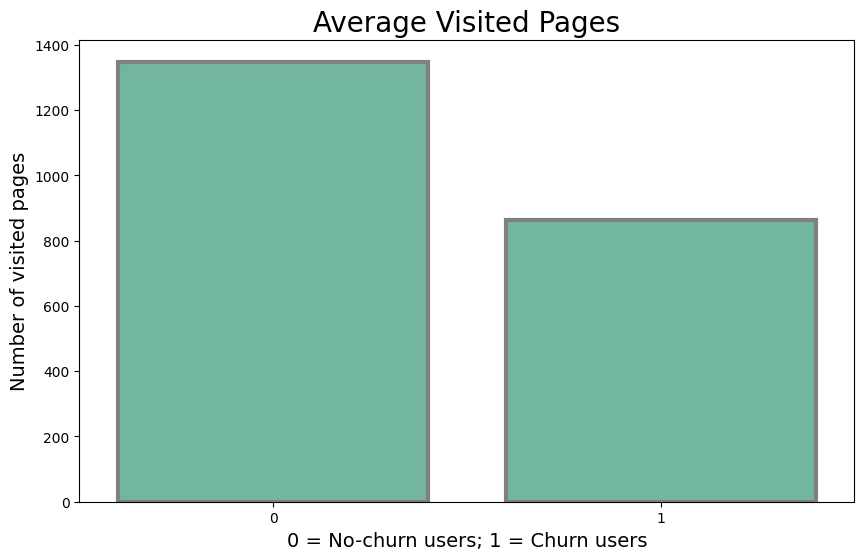

In [41]:
visited_pages_distribution = eda_df.groupby(["churn", "userId"]).count().groupby("churn").agg(F.avg("count").alias("Average Visited Pages")).toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=visited_pages_distribution, x="churn", y="Average Visited Pages", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Average Visited Pages", fontsize=20)
ax.set_xlabel("0 = No-churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Number of visited pages", fontsize=14)
fig.savefig("images/visited_pages_distribution.jpg");

Users that remained on the platform, on average, visited more pages.

#### Distribution of the Average Number of Songs Listened by Every User

/tmp/ipykernel_17359/3139168739.py:3: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '.5'}` instead.

  sns.barplot(data=listened_songs_distribution, x="churn", y="Average Songs Played", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)


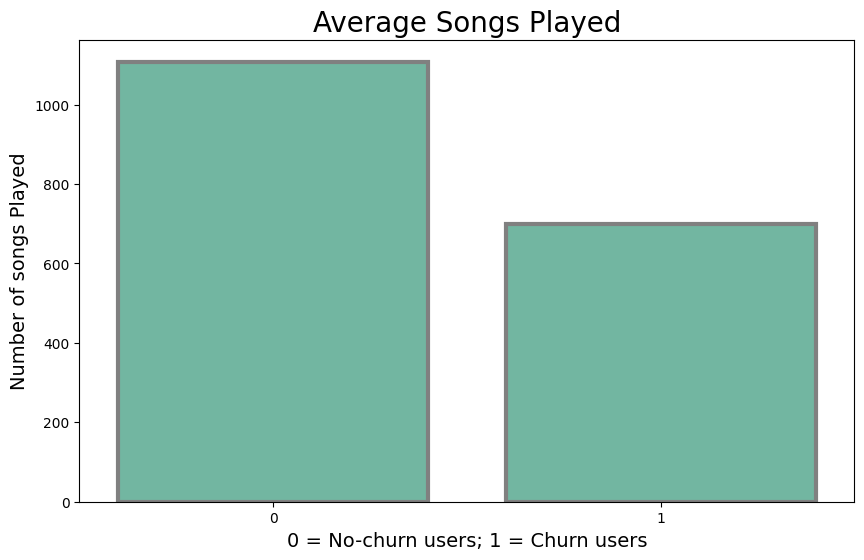

In [42]:
listened_songs_distribution = eda_df.where(F.col("artist") != "unknown").groupby(["churn", "userId"]).count().groupby("churn").agg(F.avg("count").alias("Average Songs Played")).toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=listened_songs_distribution, x="churn", y="Average Songs Played", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Average Songs Played", fontsize=20)
ax.set_xlabel("0 = No-churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Number of songs Played", fontsize=14)
fig.savefig("images/listened_songs_distribution.jpg");

Users that remained on the platform, on average, are listening to more songs.

#### Distribution of the Average Number of Artists Listened by Every User

/tmp/ipykernel_17359/3133438474.py:11: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '.5'}` instead.

  sns.barplot(data=listened_artists_distribution, x="churn", y="Average Listened Artists", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)


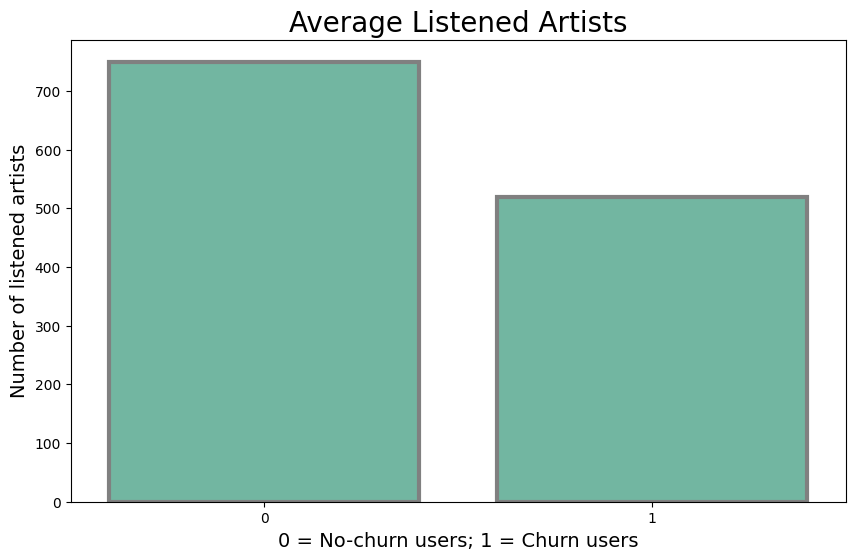

In [43]:
listened_artists_distribution = eda_df \
    .select(["artist", "userId", "churn"]) \
    .where(F.col("artist") != "unknown") \
    .distinct() \
    .groupby(["churn", "userId"]) \
    .count() \
    .groupby("churn") \
    .agg(F.avg("count").alias("Average Listened Artists")) \
    .toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=listened_artists_distribution, x="churn", y="Average Listened Artists", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Average Listened Artists", fontsize=20)
ax.set_xlabel("0 = No-churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Number of listened artists", fontsize=14)
fig.savefig("images/listened_artists_distribution.jpg");

On average, users that remain on the platform are listening to a wider variety of artists.

#### Average Seconds of Listened Music

/tmp/ipykernel_17359/2422526345.py:10: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '.5'}` instead.

  sns.barplot(data=average_listened_seconds_distribution, x="churn", y="Average Seconds of Listened Music", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)


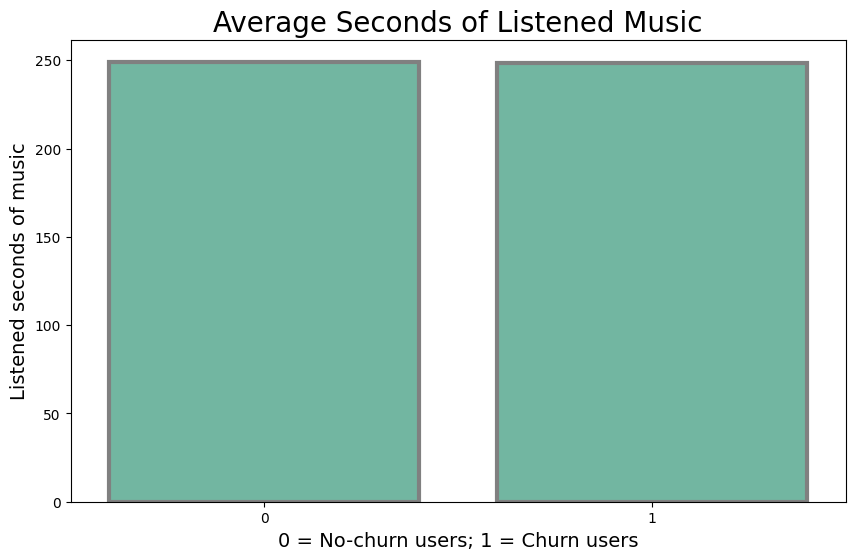

In [44]:
average_listened_seconds_distribution = eda_df \
    .select(["artist", "userId", "churn", "length"]) \
    .where(F.col("artist") != "unknown") \
    .groupby(["churn", "userId"]) \
    .agg(F.avg(F.col("length")).alias("averageLength")) \
    .groupby("churn") \
    .agg(F.avg(F.col("averageLength")).alias("Average Seconds of Listened Music")) \
    .toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=average_listened_seconds_distribution, x="churn", y="Average Seconds of Listened Music", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Average Seconds of Listened Music", fontsize=20)
ax.set_xlabel("0 = No-churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Listened seconds of music", fontsize=14)
fig.savefig("images/average_listened_seconds_distribution.jpg");

The average seconds of listened music is similar for both churn and no-churn groups. Therefore, this feature won't have much predictive power.

#### Different Level of Users

/tmp/ipykernel_17359/904085033.py:8: FutureWarning: 

The `errcolor` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'color': '.5'}` instead.

  sns.barplot(data=levels_distribution, x="churn", y="Levels of Users", hue="level", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)


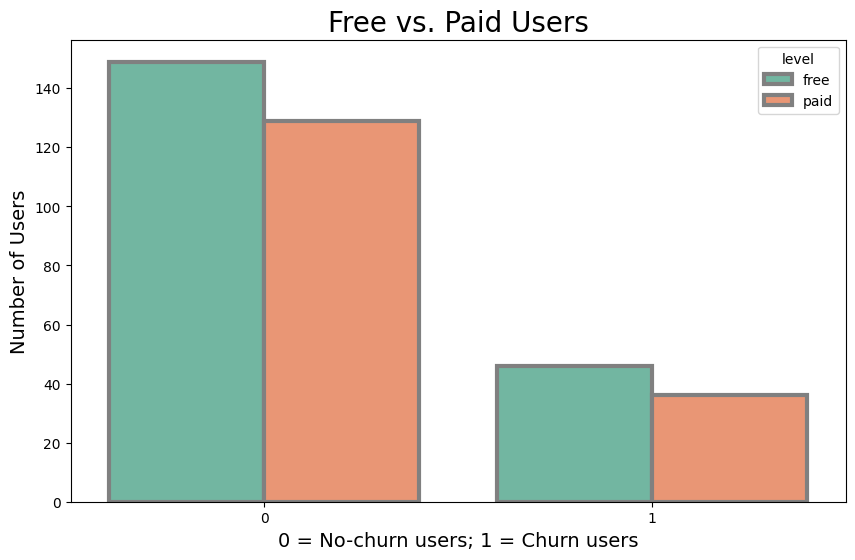

In [45]:
levels_distribution = eda_df \
    .select(["userId", "level", "churn"]) \
    .distinct() \
    .groupby("churn", "level") \
    .agg(F.count(F.col("userId")).alias("Levels of Users")) \
    .toPandas()
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
sns.barplot(data=levels_distribution, x="churn", y="Levels of Users", hue="level", errorbar=("pi", 50), capsize=.4, errcolor=".5", linewidth=3, edgecolor=".5", ax=ax)
ax.set_title("Free vs. Paid Users", fontsize=20)
ax.set_xlabel("0 = No-churn users; 1 = Churn users", fontsize=14)
ax.set_ylabel("Number of Users", fontsize=14)
fig.savefig("images/levels_distribution.jpg");

In [46]:
levels_distribution

,churn,level,Levels of Users
0,0,free,149
1,0,paid,129
2,1,paid,36
3,1,free,46


In [47]:
no_churn_users = levels_distribution[levels_distribution["churn"] == 0]
paid_users_proportion = no_churn_users.iloc[1]["Levels of Users"] / no_churn_users["Levels of Users"].sum()
print(f"Paid users proportion for no-churn users: {paid_users_proportion*100:.2f}%")

Paid users proportion for no-churn users: 46.40%


In [48]:
no_churn_users = levels_distribution[levels_distribution["churn"] == 1]
paid_users_proportion = no_churn_users.iloc[0]["Levels of Users"] / no_churn_users["Levels of Users"].sum()
print(f"Paid users proportion for churn users: {paid_users_proportion*100:.2f}%")

Paid users proportion for churn users: 43.90%


There is no huge difference for the users that are paying for a subscription between the churn and no-churn groups.

*Note:* A more robust verification can be done with a proportion statistical test.

# Feature Engineering

#### Aggregate Data at the User Level
The churn classification will be performed at the user level. Therefore, we need to aggregate the data for every user. All the features will be a result of this aggregation.

In [49]:
def count_with_condition(condition):
    """Utility function to count only specific rows based on the 'condition'."""
    return F.count(F.when(condition, True))


def count_distinct_with_condition(condition, values):
    """Utility function to count only distinct & specific rows based on the 'condition'."""
    return F.count_distinct(F.when(condition, values))

Based on the EDA step, we chose the features that divide the most the `churn` and `no-churn` user groups:
- The total number of visited pages.
- The total number of songs played.
- The total number of total artists.
- Timestamp since registration (in seconds)

In [50]:
aggregated_df = labeled_df.groupby("userId").agg(
    F.count("page").alias("numPagesVisited"),
    count_with_condition(F.col("page") == "NextSong").alias("numTotalPlays"),
    count_distinct_with_condition(F.col("artist") != "unknown", F.col("artist")).alias("numTotalArtists"),
    F.max(F.col("ts") - F.col("registration")).alias("timedeltaSinceRegistration"),
    F.max("churn").alias("churn")
)
aggregated_df.show(n=5)

+------+---------------+-------------+---------------+--------------------------+-----+
|userId|numPagesVisited|numTotalPlays|numTotalArtists|timedeltaSinceRegistration|churn|
+------+---------------+-------------+---------------+--------------------------+-----+
|100010|            381|          275|            252|                4807612000|    0|
|100014|            310|          257|            233|                7351206000|    1|
|100021|            319|          230|            207|                5593438000|    1|
|   101|           2149|         1797|           1241|                4662657000|    1|
|    11|            848|          647|            534|               10754921000|    0|
+------+---------------+-------------+---------------+--------------------------+-----+
only showing top 5 rows



#### Create the Feature Vector and Labels

In [51]:
assembler = VectorAssembler(inputCols=["numPagesVisited", "numTotalPlays", "timedeltaSinceRegistration", "numTotalArtists"], outputCol="unscaled_features")
engineered_df = assembler.transform(aggregated_df)
engineered_df = engineered_df.select(F.col("unscaled_features"), F.col("churn").alias("label"))
engineered_df.show()

+--------------------+-----+
|   unscaled_features|label|
+--------------------+-----+
|[381.0,275.0,4.80...|    0|
|[310.0,257.0,7.35...|    1|
|[319.0,230.0,5.59...|    1|
|[2149.0,1797.0,4....|    1|
|[848.0,647.0,1.07...|    0|
|[4825.0,4079.0,1....|    0|
|[11.0,8.0,6.16177...|    1|
|[2304.0,1928.0,5....|    0|
|[2469.0,2070.0,5....|    0|
|[2278.0,1914.0,4....|    0|
|[118.0,84.0,2.062...|    0|
|[1002.0,820.0,2.0...|    0|
|[474.0,387.0,6.05...|    0|
|[3603.0,3028.0,5....|    1|
|[4428.0,3632.0,6....|    0|
|[2464.0,2111.0,1....|    1|
|[3437.0,2841.0,9....|    1|
|[1342.0,1125.0,6....|    0|
|[201.0,150.0,6.28...|    0|
|[964.0,681.0,4.14...|    1|
+--------------------+-----+
only showing top 20 rows



# Modeling
We will train and test three models:
- Logistic Regression
- Naive Bayes
- Gradient Boosting Tree

We will use cross-validation with 3 folds to find the best hyper-parameters.

We will use 80% in the train split and 20% in the test split.

We normalized the features using a StandardScaler.

Because the labels are highly imbalanced, we will use the `F1 score` to evaluate the models. The F1 score metric is using under the hood the precision and recall which are taking into consideration the unbalanced distribution issue.

In [52]:
def run(pipeline, paramGrid, train_df, test_df):
    """
    Main function used to train & test a given model.
    The training step uses cross-validation to find the best hyper-parameters for the model.

    :param pipeline: Model pipeline.
    :param paramGrid: Parameter grid used for cross-validation.
    :param train_df: Training dataframe.
    :param test_df: Testing dataframe.
    :return: the best model from cross-validation.
    """

    fitted_model = fit_model(paramGrid, pipeline, train_df)
    evaluate_model(fitted_model, test_df)

    return fitted_model


def fit_model(paramGrid, pipeline, train_df):
    """
    Function that trains the model using cross-validation.
    Also, it prints the best validation results and hyper-parameters.

    :param paramGrid: Parameter grid used for cross-validation.
    :param pipeline: Model pipeline.
    :param train_df: Training dataframe.
    :return: the best model from cross-validation.
    """

    crossval = CrossValidator(
        estimator=pipeline,
        estimatorParamMaps=paramGrid,
        evaluator=MulticlassClassificationEvaluator(metricName="f1", beta=1.0),
        parallelism=3,
        numFolds=3
    )

    fitted_model = crossval.fit(train_df)
    print_best_validation_score(fitted_model)
    print_best_parameters(fitted_model)

    return fitted_model


def create_pipeline(model):
    """
    Create a pipeline based on a model.

    :param model: The end model that will be used for training.
    :return: the built pipeline.
    """

    scaler = StandardScaler(inputCol="unscaled_features", outputCol="features")
    pipeline = Pipeline(stages=[scaler, model])

    return pipeline


def print_best_validation_score(cross_validation_model):
    """Prints the best validation score based on the results from the cross-validation model."""
    print()
    print("-" * 60)
    print(f"F1 score, on the validation split, for the best model: {np.max(cross_validation_model.avgMetrics) * 100:.2f}%")
    print("-" * 60)


def print_best_parameters(cross_validation_model):
    """Prints the best hyper-parameters based on the results from the cross-validation model."""

    parameters = cross_validation_model.getEstimatorParamMaps()[np.argmax(cross_validation_model.avgMetrics)]

    print()
    print("-" * 60)
    print("Best model hyper-parameters:")
    for param, value in parameters.items():
        print(f"{param}: {value}")
    print("-" * 60)


def evaluate_model(model, test_df):
    """Evaluate the model on the test set using F1 score and print the results."""

    predictions = model.transform(test_df)
    evaluator =  MulticlassClassificationEvaluator(metricName="f1", beta=1.0)
    metric = evaluator.evaluate(predictions)

    print()
    print("-" * 60)
    print(f"F1 score, on the test set is: {metric*100:.2f}%")
    print("-" * 60)

    return metric

## Split the Data

In [53]:
train_df, test_df = engineered_df.randomSplit([0.8, 0.2], seed=42)

## Logistic Regression

In [54]:
lr = LogisticRegression()
pipeline = create_pipeline(lr)

paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 25, 50])  \
    .addGrid(lr.regParam, [0.05, 0.1, 0.2]) \
    .addGrid(lr.elasticNetParam, [0.05, 0.1, 0.2]) \
    .build()

In [55]:
run(pipeline, paramGrid, train_df.alias("train_df_lr"), test_df.alias("test_df_lr"));

24/05/27 17:29:24 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/27 17:30:07 WARN BlockManager: Asked to remove block broadcast_1584, which does not exist



------------------------------------------------------------
F1 score, on the validation split, for the best model: 73.53%
------------------------------------------------------------

------------------------------------------------------------
Best model hyper-parameters:
LogisticRegression_15cee739104c__maxIter: 10
LogisticRegression_15cee739104c__regParam: 0.05
LogisticRegression_15cee739104c__elasticNetParam: 0.05
------------------------------------------------------------

------------------------------------------------------------
F1 score, on the test set is: 56.41%
------------------------------------------------------------


## Naive Bayes

In [56]:
nb = NaiveBayes()
pipeline = create_pipeline(nb)

paramGrid = ParamGridBuilder() \
    .addGrid(nb.smoothing, [0.5, 1, 2])  \
    .build()

In [57]:
run(pipeline, paramGrid, train_df.alias("train_df_nb"), test_df.alias("test_df_nb"));


------------------------------------------------------------
F1 score, on the validation split, for the best model: 66.32%
------------------------------------------------------------

------------------------------------------------------------
Best model hyper-parameters:
NaiveBayes_313ca47e7d08__smoothing: 0.5
------------------------------------------------------------

------------------------------------------------------------
F1 score, on the test set is: 56.41%
------------------------------------------------------------


## Gradient Boosting

In [58]:
gbt = GBTClassifier()
pipeline = create_pipeline(gbt)

paramGrid = ParamGridBuilder() \
    .addGrid(gbt.maxIter, [10, 20, 30]) \
    .addGrid(gbt.stepSize, [0.05, 0.1]) \
    .build()

In [59]:
run(pipeline, paramGrid, train_df.alias("train_df_gbt"), test_df.alias("test_df_gbt"));


------------------------------------------------------------
F1 score, on the validation split, for the best model: 75.69%
------------------------------------------------------------

------------------------------------------------------------
Best model hyper-parameters:
GBTClassifier_6a68d58c4a9f__maxIter: 30
GBTClassifier_6a68d58c4a9f__stepSize: 0.1
------------------------------------------------------------

------------------------------------------------------------
F1 score, on the test set is: 74.79%
------------------------------------------------------------


# Results

|        Model        | Validation |   Test   |
|:-------------------:|:----------:|:--------:|
| Logistic Regression |   0.6958   |  0.5952  |
|     Naive Bayes     |   0.6672   |  0.5952  |
|  Gradient Boosting  |  *0.7333*  | *0.8473* |

The GBT model has a better `F1 score` than Logistic Regression and Naive Bayes. This is because GBT is a more complex model that can understand non-linear relationships better.

Usually,  Gradient Boosting methods perform better than other methods such as LR or NB without taking into consideration factors such as correlation between two variables or non-linear relationships. Tree base models are not sensitive to those issues because they create leaves independently.

# Conclusion

Great! We managed to train a decent classifier using only Spark.

We loaded the dataset, cleaned it, analyzed it, and in the end, we created a set of useful features to predict customer churn.

With the engineered data, we trained and tested three churn prediction models. By using cross-validation, we find the best hyper-parameters for the following models:
- Logistic Regression
- Naive Bayes
- Gradient Boosting
We compared the results and saw that the GBT model had the highest `F1 score` on the validation and test splits.

To further improve the model, we can do the following:
* add more features
* solve the label imbalance issue
* use the `Downgrade` event to generate more `churn` labels
* more hyper-parameter tuning (because some intervals used in cross-validation are hitting the lower or upper edges).
* use XGBoost or LightGBM